# Solve MNIST with Keras and Tensorboard

In [1]:
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%load_ext tensorboard

In [2]:
rm -rf ./logs/

In [3]:
# Download the training data.
mnist = tf.keras.datasets.mnist

In [4]:
# Divide into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
x_train = x_train.reshape(60000, 28, 28, 1)

In [6]:
x_test = x_test.reshape(10000, 28, 28, 1)


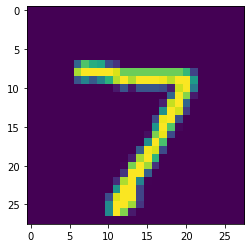

In [7]:
# Explore the data
plt.imshow(x_test[0])

plt.show()

In [8]:
from tensorflow.keras import regularizers

# Define a model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax"),
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

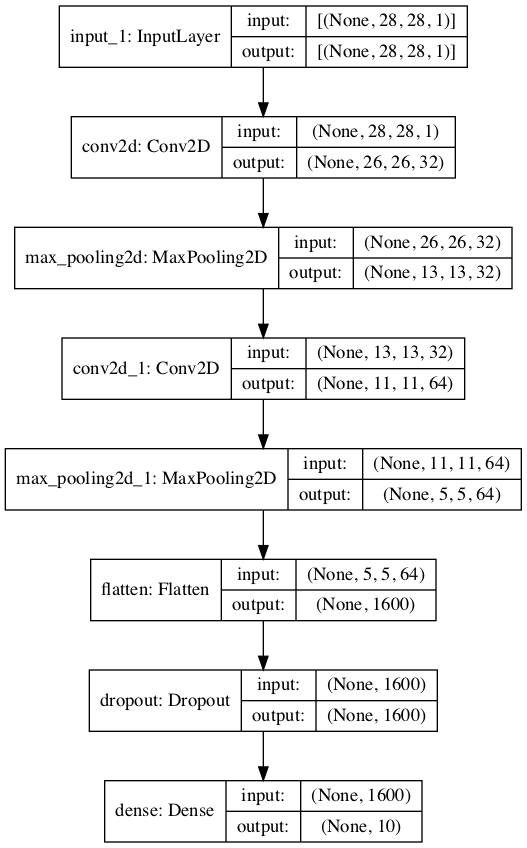

In [9]:
# Visualize the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
# Show random predictions of unfit model
predictions = model(x_train[:1]).numpy()
predictions

array([[0.09427246, 0.09584423, 0.11979246, 0.09753399, 0.08819304,
        0.10101968, 0.11669673, 0.10570621, 0.08672933, 0.09421183]],
      dtype=float32)

In [11]:
# Show the softmax of these predictions
tf.nn.softmax(predictions).numpy()

array([[0.09942335, 0.09957975, 0.10199329, 0.09974816, 0.09882075,
        0.10009646, 0.10167804, 0.10056666, 0.09867621, 0.09941733]],
      dtype=float32)

In [12]:
# Show loss on the unfit model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.301621

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

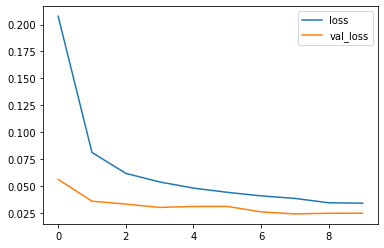

In [14]:
from IPython.display import clear_output

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()



# Set up tensorboard logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x_train, y_train,
          epochs=10,
          validation_data=(x_test, y_test),
          callbacks=[plot_losses, tensorboard_callback],
          verbose=0)

In [15]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 1712), started 0:28:44 ago. (Use '!kill 1712' to kill it.)

In [16]:
# Evaluate the model
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 4s - loss: 0.0250 - accuracy: 0.9920


[0.025042837485671043, 0.9919999837875366]

In [17]:
# Check the prediction for the same image we visualized above.
model.predict(x_test)[0].argmax()

7